In [ ]:
!pip install langdetect
!pip install stop_words

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Import library and EDA

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
import matplotlib.pyplot as plt

## for text field processing
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn import datasets, feature_extraction, decomposition
from nltk.stem.porter import PorterStemmer
nltk.download('vader_lexicon')

import gensim
from gensim import corpora
import re
import stop_words
from stop_words import get_stop_words
import operator
from gensim.models import CoherenceModel

# for non-english detection
from langdetect import detect

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
reviews_total = pd.read_csv(r'/content/reviews.csv')

In [ ]:
listings_total = pd.read_csv(r'/content/listings.csv')

In [ ]:
listings_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7566 entries, 0 to 7565
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            7566 non-null   int64  
 1   listing_url                                   7566 non-null   object 
 2   scrape_id                                     7566 non-null   int64  
 3   last_scraped                                  7566 non-null   object 
 4   source                                        7566 non-null   object 
 5   name                                          7566 non-null   object 
 6   description                                   7411 non-null   object 
 7   neighborhood_overview                         4194 non-null   object 
 8   picture_url                                   7566 non-null   object 
 9   host_id                                       7566 non-null   i

In [ ]:
reviews_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243183 entries, 0 to 243182
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   listing_id     243183 non-null  int64 
 1   id             243183 non-null  int64 
 2   date           243183 non-null  object
 3   reviewer_id    243183 non-null  int64 
 4   reviewer_name  243183 non-null  object
 5   comments       243165 non-null  object
dtypes: int64(3), object(3)
memory usage: 11.1+ MB


# Functions

In [ ]:
# Function for sentiment analysis
def sent_analysis(df,x,column_name):
    df[column_name] = 0
    sia = SentimentIntensityAnalyzer()

    for i in range(len(df)):
        s = str(df.iloc[i,df.columns.get_loc(x)])

        # Calculate sentiment score for description
        sentiment = sia.polarity_scores(s)
        df.iloc[i, df.columns.get_loc(column_name)] = sentiment["compound"]

In [ ]:
# Function to remove non-english row
def drop_nonen_row(df,x):
    index_remove = []
    for i in range(len(df)):
      try:
        if detect(df.iloc[i,df.columns.get_loc(x)]) != 'en':
            index_remove.append(i)
      except:
        index_remove.append(i)

    # print(index_remove)
    df_drop = df.drop(index_remove)
    df_drop = df_drop.reset_index(drop=True)
    return df_drop

# Data cleaning and feature engineering for listings

In [ ]:
keep = ['id','description','host_response_time','host_response_rate','host_acceptance_rate',
     'host_is_superhost','host_has_profile_pic','host_identity_verified',
     'neighbourhood_cleansed','room_type','accommodates','bathrooms_text',
     'bedrooms','beds','amenities','price','has_availability',
     'review_scores_rating','review_scores_accuracy','review_scores_cleanliness',
     'review_scores_checkin','review_scores_communication','review_scores_location',
     'review_scores_value','instant_bookable','reviews_per_month']
listings = listings_total[keep]

In [ ]:
pd.isnull(listings).sum()

id                                0
description                     155
host_response_time             3634
host_response_rate             3634
host_acceptance_rate           3375
host_is_superhost                 0
host_has_profile_pic              0
host_identity_verified            0
neighbourhood_cleansed            0
room_type                         0
accommodates                      0
bathrooms_text                    4
bedrooms                        205
beds                             94
amenities                         0
price                             0
has_availability                  0
review_scores_rating           1357
review_scores_accuracy         1481
review_scores_cleanliness      1480
review_scores_checkin          1485
review_scores_communication    1481
review_scores_location         1485
review_scores_value            1487
instant_bookable                  0
reviews_per_month              1357
dtype: int64

In [ ]:
# Delete the row with Null review_scores_rating
listings = listings.dropna(subset = ['review_scores_rating'])
listings = listings.reset_index(drop=True)

In [ ]:
# Fill missing value with mode
def fillnamode(x):
    listings.loc[:,x] = listings.loc[:,x].fillna(listings.loc[:,x].value_counts().index[0])
    return 

fillnamode('host_response_time')
fillnamode('host_response_rate')
fillnamode('host_acceptance_rate')
fillnamode('bathrooms_text')
fillnamode('bedrooms')
fillnamode('beds')

# Fill missing value with mean
def fillnamean(x):
    listings.loc[:,x] = listings.loc[:,x].fillna(listings.loc[:,x].mean())
    return 

fillnamean('review_scores_accuracy')
fillnamean('review_scores_cleanliness')
fillnamean('review_scores_checkin')
fillnamean('review_scores_communication')
fillnamean('review_scores_location')
fillnamean('review_scores_value')

# Fill missing value with ""
listings.loc[:,'description'] = listings.loc[:,'description'].fillna('')

In [ ]:
pd.isnull(listings).sum()

id                             0
description                    0
host_response_time             0
host_response_rate             0
host_acceptance_rate           0
host_is_superhost              0
host_has_profile_pic           0
host_identity_verified         0
neighbourhood_cleansed         0
room_type                      0
accommodates                   0
bathrooms_text                 0
bedrooms                       0
beds                           0
amenities                      0
price                          0
has_availability               0
review_scores_rating           0
review_scores_accuracy         0
review_scores_cleanliness      0
review_scores_checkin          0
review_scores_communication    0
review_scores_location         0
review_scores_value            0
instant_bookable               0
reviews_per_month              0
dtype: int64

In [ ]:
# Convert host_response_time to an integer
listings.loc[listings['host_response_time'] == 'within an hour','host_response_time'] = 1
listings.loc[listings['host_response_time'] == 'within a few hours','host_response_time'] = 2
listings.loc[listings['host_response_time'] == 'within a day','host_response_time'] = 3
listings.loc[listings['host_response_time'] == 'a few days or more','host_response_time'] = 4

# Convert to float
for i in range(len(listings)):
    listings.iloc[i,listings.columns.get_loc('host_response_rate')] = float(str(listings.iloc[i,listings.columns.get_loc('host_response_rate')]).strip("%"))/100

for i in range(len(listings)):
    listings.iloc[i,listings.columns.get_loc('host_acceptance_rate')] = float(str(listings.iloc[i,listings.columns.get_loc('host_acceptance_rate')]).strip("%"))/100
    
# Clean bathroom number
for i in range(len(listings)):
    listings.iloc[i,listings.columns.get_loc('bathrooms_text')] = str(listings.iloc[i,listings.columns.get_loc('bathrooms_text')]).replace("Shared half-bath", "0.5 bath").replace("Half-bath", "0.5 bath").replace("Private half-bath", "0.5 bath")

for i in range(len(listings)):
    listings.iloc[i,listings.columns.get_loc('bathrooms_text')] = float(listings.iloc[i,listings.columns.get_loc('bathrooms_text')].split(" ")[0])
    
# Convert to bool
def convert_bool(x):
    listings.loc[listings[x] == 'f',x] = 0
    listings.loc[listings[x] == 't',x] = 1

convert_bool('host_is_superhost')
convert_bool('host_has_profile_pic')
convert_bool('host_identity_verified')
convert_bool('has_availability')
convert_bool('instant_bookable')

# Clean price
for i in range(len(listings)):
    listings.iloc[i,listings.columns.get_loc('price')] = float(str(listings.iloc[i,listings.columns.get_loc('price')]).replace("$", "").replace(",", ""))

In [ ]:
# Create new features

# Calculate the share of bathrooms, bedrooms and beds and  per person
listings = listings.assign(
    bathroom_per_person = listings.bathrooms_text/listings.accommodates,
    bedroom_per_person = listings.bedrooms/listings.accommodates,
    bed_per_person = listings.beds/listings.accommodates)

for i in range(len(listings)):
    listings.iloc[i,listings.columns.get_loc('bedroom_per_person')] = format(listings.iloc[i,listings.columns.get_loc('bedroom_per_person')], '.2f')

for i in range(len(listings)):
    listings.iloc[i,listings.columns.get_loc('bed_per_person')] = format(listings.iloc[i,listings.columns.get_loc('bed_per_person')], '.2f')

In [ ]:
# Dummy ecoding
def dummy_ecoding(x):
    dummies = pd.get_dummies(listings[x])
    merged = pd.concat([listings, dummies], axis='columns')
    final = merged.drop([x], axis='columns')
    return final

listings = dummy_ecoding('neighbourhood_cleansed')
listings = dummy_ecoding('room_type')

In [ ]:
# Processing amenities
listings_amenities = pd.DataFrame(index = range(len(listings)))
listings_amenities['id'] = listings['id']

def amenities_in(x):
    # Create a new column called x and set all values to 0
    listings_amenities[x] = 0

    # Loop through the rows of the DataFrame
    for i in range(len(listings['amenities'])):
        content = ast.literal_eval(listings.iloc[i, listings.columns.get_loc('amenities')])
        if x in content:
        # If the word x appears in the content, set the value of the x column to 1
            listings_amenities.loc[i, x] = 1

In [ ]:
amenities_keyword = ["Oven", "Fire extinguisher", "Dryer", "Hangers", "Kitchen", 
                     "Cooking basics", "Breakfast", "Microwave", "Heating", "Washer", 
                     "First aid kit", "Hot water", "Iron", "Dishwasher", 
                     "Shampoo", "Luggage dropoff allowed", "Coffee maker", "Essentials", 
                     "Refrigerator", "Bed linens", "Wifi", "Self check-in", "Pets allowed", "Elevator"]

In [ ]:
for i in amenities_keyword:
    amenities_in(i)

In [ ]:
# Merge listings and listings_amenities
listings = pd.merge(listings, listings_amenities,on=['id'])

[Text(0, 0, 'review_scores_rating'),
 Text(0, 0, 'review_scores_accuracy'),
 Text(0, 0, 'review_scores_cleanliness'),
 Text(0, 0, 'review_scores_checkin'),
 Text(0, 0, 'review_scores_communication'),
 Text(0, 0, 'review_scores_location'),
 Text(0, 0, 'review_scores_value')]

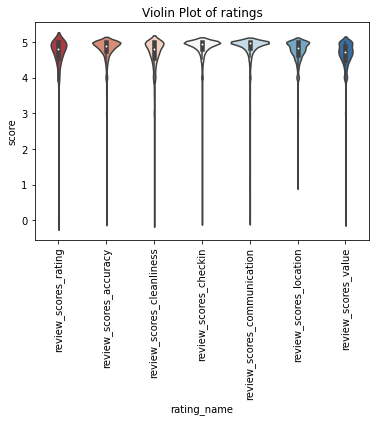

In [ ]:
# Draw violin plot
tmp=pd.melt(listings,id_vars='id',
            value_vars=["review_scores_rating","review_scores_accuracy","review_scores_cleanliness","review_scores_checkin","review_scores_communication","review_scores_location","review_scores_value"],
            var_name='rating_name',
            value_name='score')

# Visualization
viz = sns.violinplot(x = 'rating_name',
               y = 'score',
               data = tmp, 
               #scale = 'count', 
               palette = 'RdBu' 
              )

viz.set_title('Violin Plot of ratings')
viz.set_xticklabels(viz.get_xticklabels(),rotation = 90)

In [ ]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6209 entries, 0 to 6208
Data columns (total 59 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           6209 non-null   int64  
 1   description                  6209 non-null   object 
 2   host_response_time           6209 non-null   object 
 3   host_response_rate           6209 non-null   object 
 4   host_acceptance_rate         6209 non-null   object 
 5   host_is_superhost            6209 non-null   object 
 6   host_has_profile_pic         6209 non-null   object 
 7   host_identity_verified       6209 non-null   object 
 8   accommodates                 6209 non-null   int64  
 9   bathrooms_text               6209 non-null   object 
 10  bedrooms                     6209 non-null   float64
 11  beds                         6209 non-null   float64
 12  amenities                    6209 non-null   object 
 13  price             

# Data cleaning and feature engineering for review

In [ ]:
reviews_total.shape

(243183, 6)

In [ ]:
reviews_total.drop(['id', 'date', 'reviewer_id', 'reviewer_name'], axis = 1, inplace = True)

In [ ]:
reviews_total.head()

,listing_id,comments
0,44077,We enjoyed our stay very much. The room was co...
1,44077,We have been here 4 nights. Stay in a home is ...
2,44077,Teresa and Hughie were great hosts. They were ...
3,44077,"No surprises, was as described. Very gracious..."
4,44077,"Teresa was a lovely hostess, and we had a deli..."


In [ ]:
reviews_en = drop_nonen_row(reviews_total,'comments')

In [ ]:
reviews_en.shape

(210152, 2)

In [ ]:
reviews_en.head()

,listing_id,comments
0,44077,We enjoyed our stay very much. The room was co...
1,44077,We have been here 4 nights. Stay in a home is ...
2,44077,Teresa and Hughie were great hosts. They were ...
3,44077,"No surprises, was as described. Very gracious..."
4,44077,"Teresa was a lovely hostess, and we had a deli..."


# Sentiment analysis

In [ ]:
# Handle listings['description']
sent_analysis(listings,'description','Host_sentiment_score')

In [ ]:
# Handle reviews_total['comments']
sent_analysis(reviews_en,'comments','Cust_sentiment_score')

In [ ]:
# Drop the Features that are not needed
listings.drop(['accommodates', 'beds', 'bedrooms', 'bathrooms_text', 'amenities', 'description'], axis = 1, inplace = True)
reviews_en.drop(['comments'], axis = 1, inplace = True)

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6209 entries, 0 to 6208
Data columns (total 54 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           6209 non-null   int64  
 1   host_response_time           6209 non-null   object 
 2   host_response_rate           6209 non-null   object 
 3   host_acceptance_rate         6209 non-null   object 
 4   host_is_superhost            6209 non-null   object 
 5   host_has_profile_pic         6209 non-null   object 
 6   host_identity_verified       6209 non-null   object 
 7   price                        6209 non-null   object 
 8   has_availability             6209 non-null   object 
 9   review_scores_rating         6209 non-null   float64
 10  review_scores_accuracy       6209 non-null   float64
 11  review_scores_cleanliness    6209 non-null   float64
 12  review_scores_checkin        6209 non-null   float64
 13  review_scores_comm

In [ ]:
reviews_en.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210152 entries, 0 to 210151
Data columns (total 2 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   listing_id            210152 non-null  int64  
 1   Cust_sentiment_score  210152 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 3.2 MB


In [ ]:
listings.to_csv('listings_clean.csv')

In [ ]:
reviews_en.to_csv('reviews_clean.csv')